In [5]:

import math
import keras
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

from keras.models import Sequential, model_from_json
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from google.colab import files

plt.style.use('default')

In [1]:
import io
import pandas
from datetime import datetime
import requests

class YahooData:
  def fetch(ticker, start, end):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/601.3.9 (KHTML, like Gecko) Version/9.0.2 Safari/601.3.9'
    }

    url = "https://query1.finance.yahoo.com/v7/finance/download/" + str(ticker)
    x = int(datetime.strptime(start, '%Y-%m-%d').strftime("%s"))
    y = int(datetime.strptime(end, '%Y-%m-%d').strftime("%s"))
    url += "?period1=" + str(x) + "&period2=" + str(y) + "&interval=1d&events=history&includeAdjustedClose=true"
    
    r = requests.get(url, headers=headers)
    pd = pandas.read_csv(io.StringIO(r.text), index_col=0, parse_dates=True)

    return pd

In [2]:
df = YahooData.fetch("AAPL", start="2015-01-01", end="2022-06-30")
print(df)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2015-01-02   27.847500   27.860001   26.837500   27.332500   24.644020   
2015-01-05   27.072500   27.162500   26.352501   26.562500   23.949757   
2015-01-06   26.635000   26.857500   26.157499   26.565001   23.952013   
2015-01-07   26.799999   27.049999   26.674999   26.937500   24.287874   
2015-01-08   27.307501   28.037500   27.174999   27.972500   25.221071   
...                ...         ...         ...         ...         ...   
2022-06-23  136.820007  138.589996  135.630005  138.270004  138.078201   
2022-06-24  139.899994  141.910004  139.770004  141.660004  141.463501   
2022-06-27  142.699997  143.490005  140.970001  141.660004  141.463501   
2022-06-28  142.130005  143.419998  137.320007  137.440002  137.249359   
2022-06-29  137.460007  140.669998  136.669998  139.229996  139.036865   

               Volume  
Date         

In [3]:
df = df.reset_index()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.644020,212818400
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,23.949757,257142000
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,23.952013,263188400
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,24.287874,160423600
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,25.221071,237458000


In [6]:
df['EMA12'] = df['Adj Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Adj Close'].ewm(span=26, adjust=False).mean()

df['MACD'] = df['EMA12'] - df['EMA26']
df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean() 

df['OBV'] = np.where(df['Adj Close'] == df['Adj Close'].shift(1), 0, np.where(df['Adj Close'] > df['Adj Close'].shift(1), df['Volume'], 
        np.where(df['Adj Close'] < df['Adj Close'].shift(1), -df['Volume'], df.iloc[0]['Volume']))).cumsum() # on-balance volume
df['OBV Percent'] = df['OBV'].pct_change() * 100
df['OBV Percent'] = round(df['OBV Percent'].fillna(0), 2) # on-balance volume as a percentage

df['Adj Close Delta'] = df['Adj Close'].diff().fillna(0) # delta between adj close

df['Next Adj Close'] = df['Adj Close'].shift(-1)
df.dropna(inplace=True)
df

,Date,Open,High,Low,Close,Adj Close,Volume,EMA12,EMA26,MACD,Signal,OBV,OBV Percent,Adj Close Delta,Next Adj Close
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.644020,212818400,24.644020,24.644020,0.000000,0.000000,212818400,0.00,0.000000,23.949757
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,23.949757,257142000,24.537210,24.592593,-0.055383,-0.011077,-44323600,-120.83,-0.694263,23.952013
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,23.952013,263188400,24.447180,24.545143,-0.097963,-0.028454,218864800,-593.79,0.002256,24.287874
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,24.287874,160423600,24.422671,24.526086,-0.103414,-0.043446,379288400,73.30,0.335861,25.221071
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,25.221071,237458000,24.545502,24.577566,-0.032064,-0.041170,616746400,62.61,0.933197,25.248119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,2022-06-22,134.789993,137.759995,133.910004,135.350006,135.162262,73409200,136.945147,141.672486,-4.727339,-4.394050,4468853200,-1.62,-0.519272,138.078201
1881,2022-06-23,136.820007,138.589996,135.630005,138.270004,138.078201,72433800,137.119463,141.406243,-4.286780,-4.372596,4541287000,1.62,2.915939,141.463501
1882,2022-06-24,139.899994,141.910004,139.770004,141.660004,141.463501,89116800,137.787777,141.410484,-3.622707,-4.222618,4630403800,1.96,3.385300,141.463501
1883,2022-06-27,142.699997,143.490005,140.970001,141.660004,141.463501,70207900,138.353273,141.414411,-3.061139,-3.990322,4630403800,0.00,0.000000,137.249359


In [7]:
X = df[['Open','High','Low','Close','Volume','EMA12','EMA26','MACD','Signal','OBV Percent','Adj Close Delta']]
y = df[['Next Adj Close']]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, stratify=None)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1413, 11), (472, 11), (1413, 1), (472, 1))

In [8]:
X_scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = X_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_scaled, columns=[X_train.columns])

print ('X_train inputs:', X_train.columns)

window = 1 # 1 day

X_train_window=[]
y_train_window=[]
for i in range(window, len(X_train)):
  X_train_window.append(X_scaled[i-window:i, :])
  y_train_window.append(X_scaled[i, 0])

X_train_window, y_train_window = np.array(X_train_window), np.array(y_train_window)
X_train_window = np.reshape(X_train_window, (X_train_window.shape[0], X_train_window.shape[1], len(X_train.columns)))

print ('X_train_window.shape', X_train_window.shape)
print ('y_train_window.shape', y_train_window.shape)

X_train inputs: MultiIndex([(           'Open',),
            (           'High',),
            (            'Low',),
            (          'Close',),
            (         'Volume',),
            (          'EMA12',),
            (          'EMA26',),
            (           'MACD',),
            (         'Signal',),
            (    'OBV Percent',),
            ('Adj Close Delta',)],
           )
X_train_window.shape (1412, 1, 11)
y_train_window.shape (1412,)


Epoch 1/500
1/1 - 12s - loss: 0.0872 - mse: 0.0872 - mae: 0.2276 - mape: 138.1383 - 12s/epoch - 12s/step
Epoch 2/500
1/1 - 0s - loss: 0.0856 - mse: 0.0856 - mae: 0.2240 - mape: 2495.6841 - 51ms/epoch - 51ms/step
Epoch 3/500
1/1 - 0s - loss: 0.0840 - mse: 0.0840 - mae: 0.2204 - mape: 4837.6465 - 46ms/epoch - 46ms/step
Epoch 4/500
1/1 - 0s - loss: 0.0824 - mse: 0.0824 - mae: 0.2168 - mape: 7529.1089 - 43ms/epoch - 43ms/step
Epoch 5/500
1/1 - 0s - loss: 0.0807 - mse: 0.0807 - mae: 0.2131 - mape: 10698.4697 - 45ms/epoch - 45ms/step
Epoch 6/500
1/1 - 0s - loss: 0.0790 - mse: 0.0790 - mae: 0.2094 - mape: 11302.3223 - 45ms/epoch - 45ms/step
Epoch 7/500
1/1 - 0s - loss: 0.0773 - mse: 0.0773 - mae: 0.2057 - mape: 17546.7285 - 51ms/epoch - 51ms/step
Epoch 8/500
1/1 - 0s - loss: 0.0756 - mse: 0.0756 - mae: 0.2021 - mape: 19369.7109 - 45ms/epoch - 45ms/step
Epoch 9/500
1/1 - 0s - loss: 0.0739 - mse: 0.0739 - mae: 0.1983 - mape: 21292.3027 - 45ms/epoch - 45ms/step
Epoch 10/500
1/1 - 0s - loss: 0.07

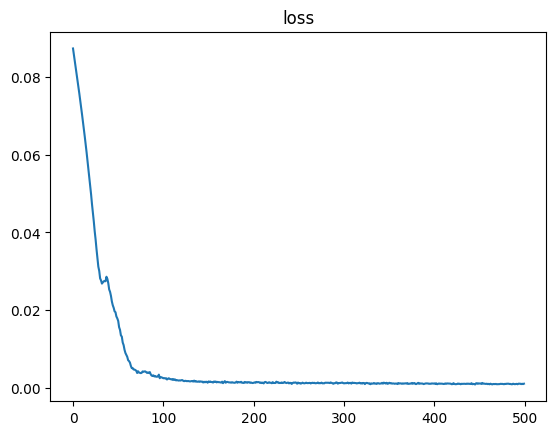

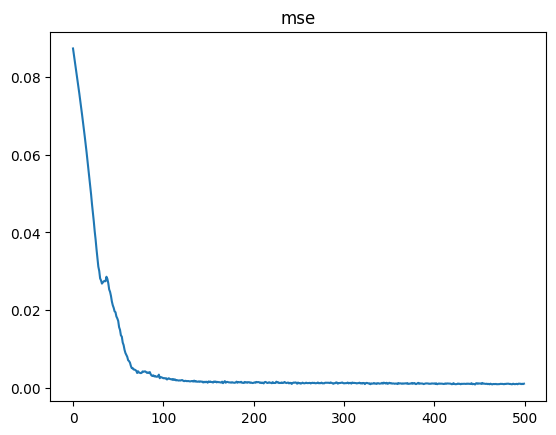

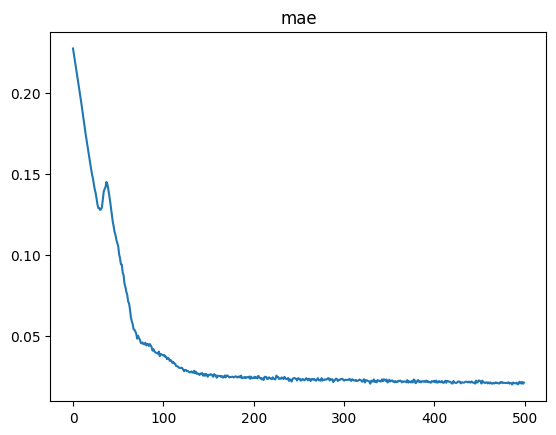

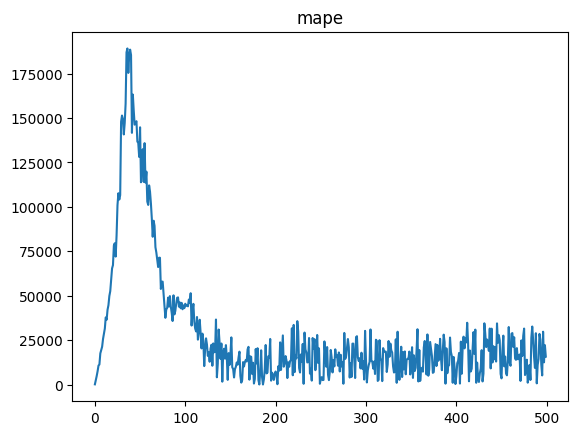

In [9]:
def create_model():
  model = Sequential()
  model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_window.shape[1], len(X_train.columns)))) # layer 1 lstm
  model.add(Dropout(0.2)) # layer 1 dropout regularisation
  model.add(LSTM(units=50, return_sequences=True)) # layer 2 lstm
  model.add(Dropout(0.2)) # layer 2 dropout regularisation
  model.add(LSTM(units=50, return_sequences=True)) # layer 3 lstm
  model.add(Dropout(0.2)) # layer 3 dropout regularisation
  model.add(LSTM(units=50)) # layer 4 lstm
  model.add(Dropout(0.2)) # layer 4 dropout regularisation
  model.add(Dense(units=1)) # output layer
  model.compile(optimizer='adam', loss='mse', metrics=['mse','mae','mape']) # compile the rnn 
  return model

model = create_model()
history = model.fit(X_train_window, y_train_window, epochs=500, batch_size=1500, verbose=2)
model.summary()

for metric in history.history:
  plt.title(metric)
  plt.plot(history.history[metric])
  plt.show()

In [10]:
'''Optionally save model, model.json and weights.h5'''

model_filename = f'model_apple_daily_{len(X_train.columns)}-inputs.json'
weights_filename = f'weights_apple_daily_{len(X_train.columns)}-inputs.h5'

!ls /content

# save structure to json
model_json = model.to_json()
with open(model_filename, 'w') as json_file:
  json_file.write(model_json)

# save weights to hdf5
model.save_weights(weights_filename)

files.download(f'/content/{model_filename}')
files.download(f'/content/{weights_filename}')

sample_data


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
'''Optionally load model, model.json and weights.h5'''

model_filename = f'model_apple_daily_{len(X_train.columns)}-inputs.json'
weights_filename = f'weights_apple_daily_{len(X_train.columns)}-inputs.h5'

try:
  files.upload()
  !ls /content

  # read structure from json
  model = open(model_filename, 'r')
  json = model.read()
  model.close()
  model = model_from_json(json)

  # read weights from hdf5
  model.load_weights(f'/content/{weights_filename}')
except Exception as e:
  print (e)

Saving weights_apple_daily_11-inputs.h5 to weights_apple_daily_11-inputs (1).h5
Saving model_apple_daily_11-inputs.json to model_apple_daily_11-inputs (3).json
'model_apple_daily_11-inputs (1).json'	 sample_data
'model_apple_daily_11-inputs (2).json'	'weights_apple_daily_11-inputs (1).h5'
'model_apple_daily_11-inputs (3).json'	 weights_apple_daily_11-inputs.h5
 model_apple_daily_11-inputs.json


In [ ]:
X_scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = X_scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_scaled, columns=[X_test.columns])

print ('X_test inputs:', X_test.columns)

y_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = y_scaler.fit_transform(y)
y_test = pd.DataFrame(y_scaled, columns=[y.columns])

print ('y_test inputs:', y_test.columns[0])

X_test_window=[]
y_test_window=[]
for i in range(window, len(X_test)):
  X_test_window.append(X_scaled[i-window:i, :])
  y_test_window.append(X_scaled[i, 0])

X_test_window, y_test_window = np.array(X_test_window), np.array(y_test_window)
X_test_window = np.reshape(X_test_window, (X_test_window.shape[0], X_test_window.shape[1], len(X_test.columns)))

print ('X_test_window.shape:', X_test_window.shape)
print ('y_test_window.shape:', y_test_window.shape)

y_pred = model.predict(X_test_window)
y_pred = y_scaler.inverse_transform(y_pred)

print ('y_pred.shape:', y_pred.shape)

In [14]:
print ('ae:', mean_absolute_error(df['Adj Close'][-len(y_pred):].values, y_pred))
print ('mse:', mean_squared_error(df['Adj Close'][-len(y_pred):].values, y_pred, squared=False))
print ('rmse:', mean_squared_error(df['Adj Close'][-len(y_pred):].values, y_pred))

ae: 42.900330303710675
mse: 46.84396849666572
rmse: 2194.35738451661


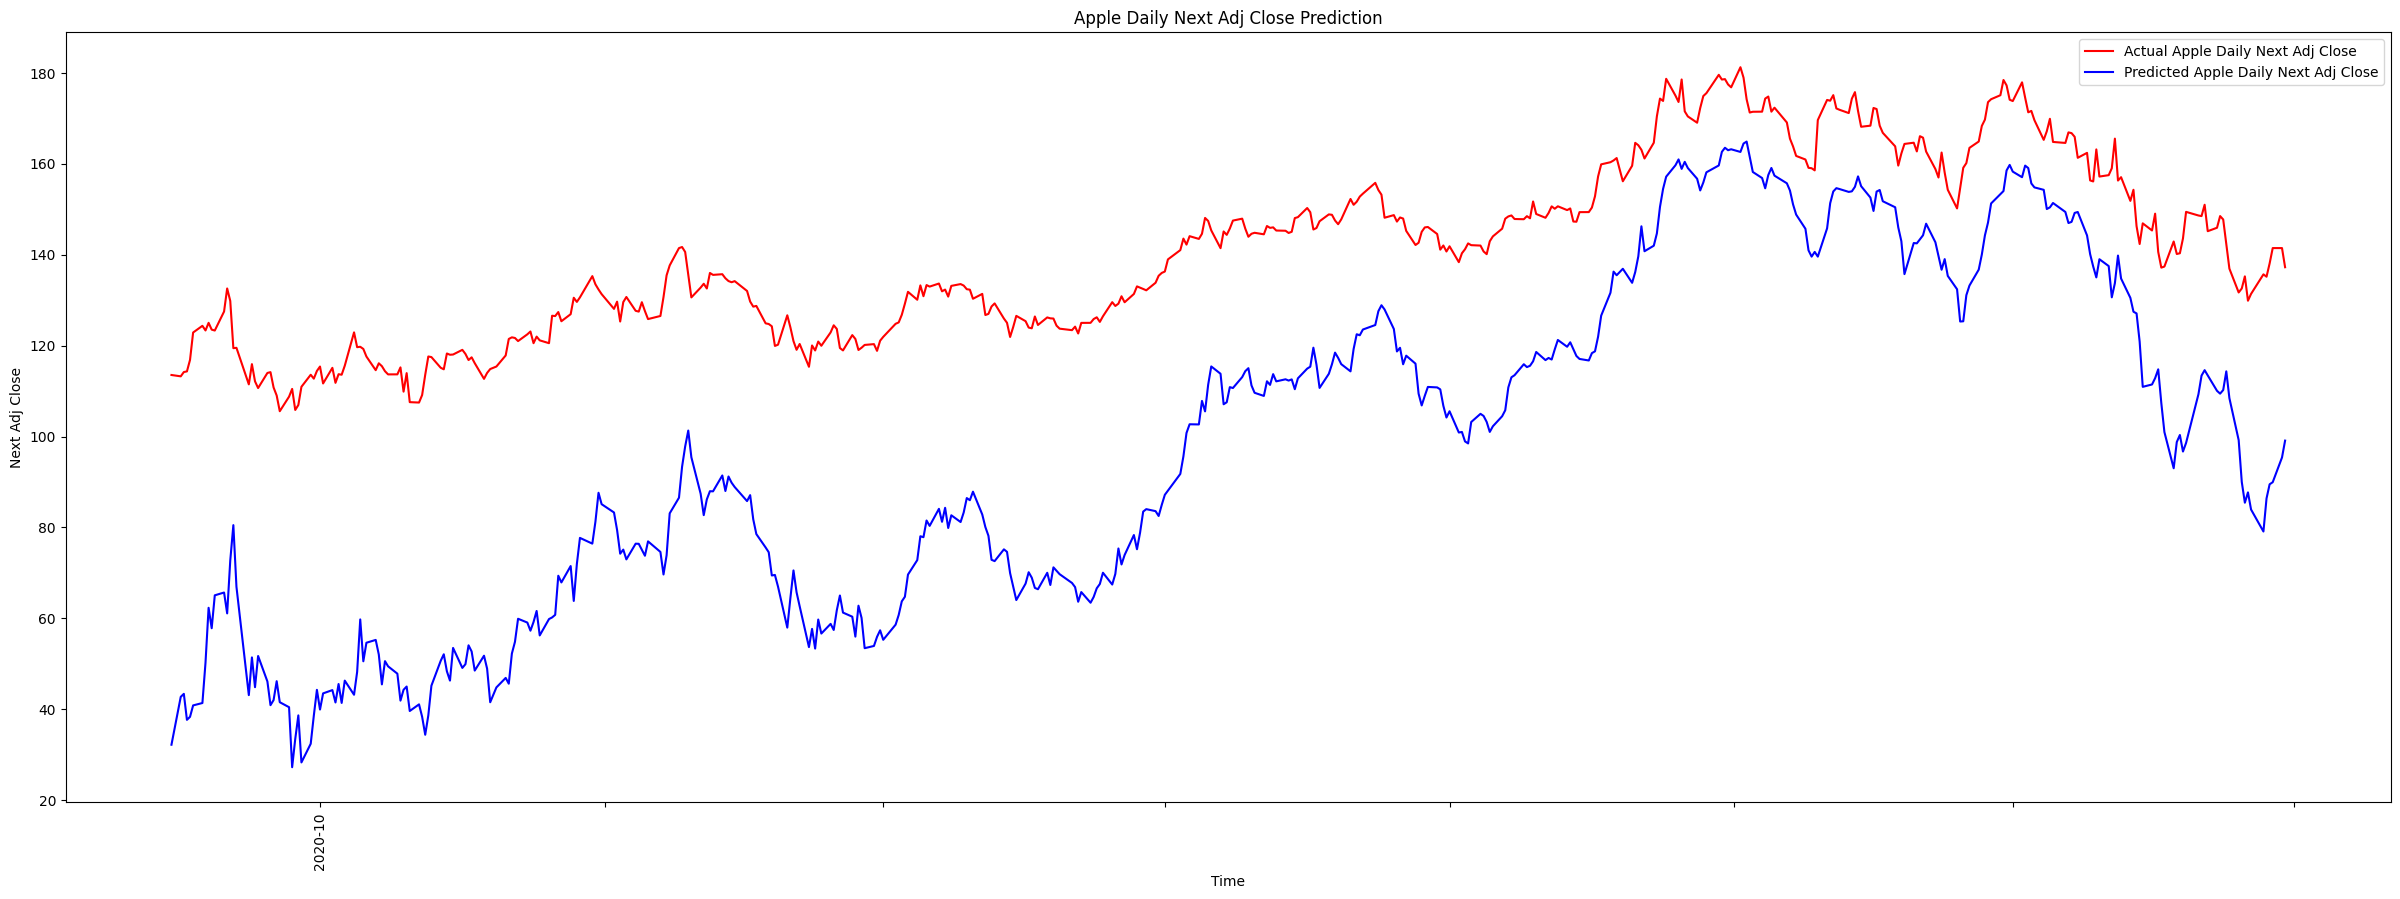

In [20]:
plt.figure(figsize=(30,10))
plt.plot(df['Date'].tail(len(y_pred)), df['Adj Close'][-len(y_pred):].values, color='red', label=f'Actual Apple Daily {y.columns.values[0].title()}')
plt.plot(df['Date'].tail(len(y_pred)), y_pred, color='blue', label=f'Predicted Apple Daily {y.columns.values[0].title()}')
plt.title(f'Apple Daily {y.columns.values[0].title()} Prediction')
plt.xlabel('Time')
plt.ylabel(f'{y.columns.values[0].title()}')
plt.xticks(rotation=90)

ax = plt.gca()
for index, label in enumerate(ax.xaxis.get_ticklabels()):
  if index % 92 != 0:
    label.set_visible(False)

plt.legend()
plt.show()

In [21]:
pd.set_option('mode.chained_assignment', None)

df_test = df.tail(len(y_pred))
df_test.loc[:, 'Predicted Next Adj Close'] = y_pred
df_test[['Open','High','Low','Close','Volume','EMA12','EMA26','MACD','Signal','OBV Percent','Adj Close Delta','Next Adj Close','Next Adj Close']]
df_test.rename(columns={'Next Adj Close': 'Actual Next Adj Close'}, errors='raise', inplace=True)
df_test

,Date,Open,High,Low,Close,Adj Close,Volume,EMA12,EMA26,MACD,Signal,OBV,OBV Percent,Adj Close Delta,Actual Next Adj Close,Predicted Next Adj Close
1414,2020-08-14,114.830002,115.000000,113.044998,114.907501,113.536949,165565200,108.268670,102.574309,5.694361,4.947521,4406441600,-3.62,-0.101280,113.240524,32.177788
1415,2020-08-17,116.062500,116.087502,113.962502,114.607498,113.240524,119561600,109.033570,103.364399,5.669171,5.091851,4286880000,-2.71,-0.296425,114.184135,42.713852
1416,2020-08-18,114.352501,116.000000,114.007500,115.562500,114.184135,105633600,109.825965,104.165861,5.660104,5.205502,4392513600,2.46,0.943611,114.327400,43.375870
1417,2020-08-19,115.982498,117.162498,115.610001,115.707497,114.327400,145538000,110.518493,104.918568,5.599926,5.284386,4538051600,3.31,0.143265,116.864273,37.653542
1418,2020-08-20,115.750000,118.392502,115.732498,118.275002,116.864273,126907200,111.494767,105.803435,5.691333,5.365776,4664958800,2.80,2.536873,122.886589,38.318695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,2022-06-22,134.789993,137.759995,133.910004,135.350006,135.162262,73409200,136.945147,141.672486,-4.727339,-4.394050,4468853200,-1.62,-0.519272,138.078201,86.373962
1881,2022-06-23,136.820007,138.589996,135.630005,138.270004,138.078201,72433800,137.119463,141.406243,-4.286780,-4.372596,4541287000,1.62,2.915939,141.463501,89.484138
1882,2022-06-24,139.899994,141.910004,139.770004,141.660004,141.463501,89116800,137.787777,141.410484,-3.622707,-4.222618,4630403800,1.96,3.385300,141.463501,89.946037
1883,2022-06-27,142.699997,143.490005,140.970001,141.660004,141.463501,70207900,138.353273,141.414411,-3.061139,-3.990322,4630403800,0.00,0.000000,137.249359,95.384277
